In [8]:
import glob # 条件を満たすpathを一括で取得してくれるライブラリ
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [25]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。
    
    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """
    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),   # 画像の拡大縮小と、サイズの変換と、タテヨコ比の変換
                transforms.RandomHorizontalFlip(), # 50%の確率で反転
                transforms.ToTensor(),  # テンソルに変換、これは常にやると思っておいたほうがよさそう(よくわかってない)
                transforms.Normalize(mean, std)   # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize*resizeで切り取る
                transforms.ToTensor(),     # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }
    
    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

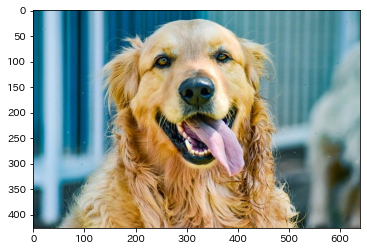

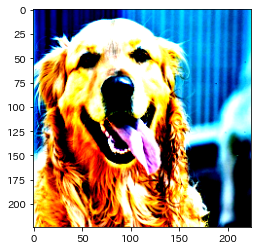

In [26]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path) # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を(高さ、幅、色)に変換し、0-1に値を制限して表示(標準化のせいで0-1を超える可能性がある)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

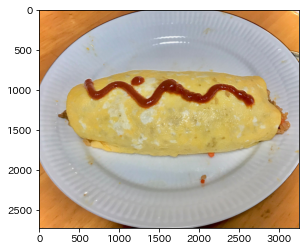

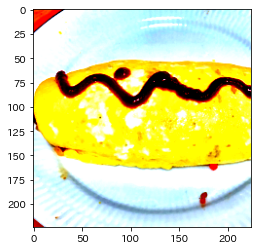

In [27]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
image_file_path = './data/IMG_2808.jpg'
img = Image.open(image_file_path) # [高さ][幅][色RGB]

# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (色、高さ、幅)を(高さ、幅、色)に変換し、0-1に値を制限して表示(標準化のせいで0-1を超える可能性がある)
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [28]:
def make_datapath_list(phase="train"):
    """
    データのパスを格納したリストを作成する。
    
    Parameters
    ----------
    phase : 'train' or 'val'
        訓練データか検証データかを指定する
    
    Returns
    -------
    path_list : list
        データへのパスを格納したリスト
    """
    
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)
    
    path_list = []  # ここに格納する
    
    # globを利用してサブディレクトリまでファイルパスを取得する
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

# 実行
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train/ants/0013035.jpg',
 './data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train/ants/116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train/ants/1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train/ants/1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train/ants/1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train/ants/132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train/ants/148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train/ants/1489674356_09d48dde0a.jpg',
 './data/hymenoptera_data/train/ants/14924

In [29]:
# アリとハチの画像のDatasetを作成する

class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。
    
    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """
    
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list # ファイルパスのリスト
        self.transform = transform # 前処理クラスのインスタンス
        self.phase = phase # train or val
        
    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)
    
    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式ののデータとラベルを取得
        '''
        
        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path) # [高さ][幅][色RGB]
        
        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
            
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
        
        return img_transformed, label

In [30]:
# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [31]:
# ミニバッチのサイズを指定
batch_size = 32

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)   # 先頭の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0])


In [32]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを作成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットをアリとハチの2つに付け替える(元々はout_features=1000だった)
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [33]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [34]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_glad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_glad = False
        
# params_to_updateの中身を確認
print("----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
----------
[Parameter containing:
tensor([[-0.0042, -0.0132,  0.0138,  ..., -0.0112, -0.0154,  0.0116],
        [ 0.0143, -0.0139, -0.0049,  ...,  0.0090, -0.0059, -0.0102]],
       requires_grad=True), Parameter containing:
tensor([ 0.0108, -0.0137], requires_grad=True)]


In [35]:
# 最適化手法の設定
# paramsで指定したparamインスタンスだけ更新してくれるのか
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

In [36]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    
    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')
        
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()  # モデルを検証モードに
                
            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0 # epochの正解数
            
            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue
                
            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                
                # optimizerを初期化
                optimizer.zero_grad()
                
                # 順伝搬(forward)計算、withの中では勾配が計算されるようになっている
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    
                    _, preds =torch.max(outputs, 1)  # ラベルを予測
                    
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    # イテレーション結果の計算
                    # lossの合計を更新(なんでこういう式になるのかわからん)
                    epoch_loss += loss.item() * inputs.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds==labels.data)
                    
            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss/len(dataloaders_dict[phase].dataset)
            # .double()はdouble型への変換
            epoch_acc = epoch_corrects.double()/len(dataloaders_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

In [37]:
# 学習・検証を実行する
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/2
----------------


  0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.6731 Acc: 0.5817
Epoch 2/2
----------------


  0%|          | 0/5 [00:00<?, ?it/s]

train Loss: 0.4755 Acc: 0.7449


100%|██████████| 5/5 [01:19<00:00, 15.90s/it]

val Loss: 0.1743 Acc: 0.9608


In [43]:
# 入力画像を読み込む
image_file_path = './data/892676922_4ab37dce07.jpg'
img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# 前処理の後、バッジサイズの次元を追加する
img_transformed = transform(img, phase="val")
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])、次元を増やしている

# モデルに入力し、モデル出力をラベルに変換する
out = net(inputs)   # torch.Size([1, 1000])

# 予測結果を出力する
print("入力画像の予測結果 : ", out)

入力画像の予測結果 :  tensor([[-0.9585,  0.3468]], grad_fn=<AddmmBackward>)


花を拾ってそう…